In [1]:
import pyforest

In [2]:
sys.path.append(str(Path.cwd().parent.absolute()))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from networks.ResNet2 import BasicBlock, ResNet, MLP
from common.dataset import CorruptedCIFAR10, ColoredMNIST
from common.tsfms import get_tsfms
from common.tools import *

In [4]:
class ResNet(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        feats = []
        out = self.layer1(out)
        feats.append(out)
        feats.append(self.aux1(out))
        out = self.layer2(out)
        feats.append(out)
        feats.append(self.aux2(out))
        out = self.layer3(out)
        feats.append(out)
        feats.append(self.aux3(out))
        out = self.layer4(out)
        feats.append(out)
        feats.append(self.aux4(out))

        out = F.adaptive_avg_pool2d(out, 1)
        out = out.flatten(1)
        feats.append(out)
        out = self.fc(out)
        feats.append(out)

        return feats

def ResNet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

In [5]:
def singular(model, loader, index):
    model.eval()

    with torch.no_grad():
        latents = []

        for _, (images, _) in enumerate(loader):
            images = images.cuda()
            feats = model(images)

            feat = feats[index]
            if feat.dim() > 2:
                feat = F.adaptive_avg_pool2d(feat, 1)
                feat = feat.flatten(1)
            latents.append(feat)

        latents = torch.cat(latents, dim=0)
        # print(f'latents shape: {latents.shape}')

        z = F.normalize(latents, dim=1)
        c = torch.cov(z.T)
        _, d, _ = torch.linalg.svd(c)

    return d.log().cpu().numpy()

In [6]:
args = edict({
    'seed': 1,
    'batch_size': 128,
    'num_workers': 8,
    'num_classes': 10,
    'data_path': '../data',
    'dataset': 'cifar10',  # mnist, cifar10
    'feat_dim': 512,
    'skewed': 0.01,
    'severity': 1,
    'epoch': 99,
    'subset': 1,  # 0 for normal, 1 for corrupted
})

<IPython.core.display.Javascript object>

In [7]:
seed_all(args.seed, benchmark=False, deterministic=True)
DataLoader = config_dloader(batch_size=args.batch_size, num_workers=args.num_workers, pin_memory=True)

In [8]:
train_tsfm, test_tsfm = get_tsfms(args.dataset)[1:]

if args.dataset == 'mnist':
    if args.subset == 0:
        DATASET = MNIST
    else:
        DATASET = partial(ColoredMNIST, skewed=0.9, severity=args.severity)
else:
    if args.subset == 0:
        DATASET = CIFAR10
    else:
        DATASET = partial(CorruptedCIFAR10, skewed=0.9, severity=args.severity)

train_data = DATASET(args.data_path, train=True, transform=train_tsfm, download=True)
test_data = DATASET(args.data_path, train=False, transform=test_tsfm)
train_loader = DataLoader(train_data, shuffle=True)
test_loader = DataLoader(test_data, shuffle=False)

<IPython.core.display.Javascript object>

Files already downloaded and verified


In [9]:
state = torch.load(
    f'../ckpts/{args.dataset}.bak/mode0_skewed{args.skewed}_severity{args.severity}/epoch{args.epoch}.pkl'
)
model = ResNet18(num_classes=args.num_classes, feat_dim=args.feat_dim)
model.fc = MLP(model.fc.in_features, model.feat_dim)
model.load_state_dict(state['model'])
model0 = model.cuda()

In [10]:
state = torch.load(
    f'../ckpts/{args.dataset}/mode4_skewed{args.skewed}_severity{args.severity}/epoch{args.epoch}.pkl'
)
model = ResNet18(num_classes=args.num_classes, feat_dim=args.feat_dim)
model.fc = MLP(model.fc.in_features, model.feat_dim)
model.load_state_dict(state['model'])
model4 = model.cuda()

In [11]:
state = torch.load(
    f'../ckpts/{args.dataset}.bak/mode5_skewed{args.skewed}_severity{args.severity}/epoch{args.epoch}.pkl'
)
model = ResNet18(num_classes=args.num_classes, feat_dim=args.feat_dim)
model.fc = MLP(model.fc.in_features, model.feat_dim)
model.load_state_dict(state['model'])
modelr = model.cuda()

In [12]:
# model = ResNet18(num_classes=args.num_classes, feat_dim=args.feat_dim)
# model.fc = MLP(model.fc.in_features, model.feat_dim)
# modelr = model.cuda()

In [13]:
d0, d4, dr = [], [], []
for i in trange(10):
    d0.append(singular(model0, test_loader, i))
    d4.append(singular(model4, test_loader, i))
    dr.append(singular(modelr, test_loader, i))

<IPython.core.display.Javascript object>

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
labels = ['instance', 'ours(new 1)', 'all instance']
prefix = f'{args.dataset} {args.skewed}'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'cifar10 0.01 layer1 after head')

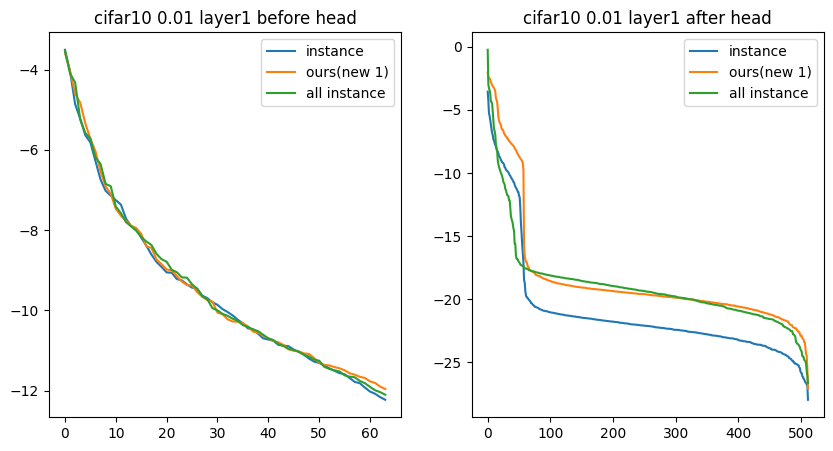

In [15]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(d0[0])
plt.plot(d4[0])
plt.plot(dr[0])
plt.legend(labels=labels)
plt.title(f'{prefix} layer1 before head')

plt.subplot(1, 2, 2)
plt.plot(d0[1])
plt.plot(d4[1])
plt.plot(dr[1])
plt.legend(labels=labels)
plt.title(f'{prefix} layer1 after head')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'cifar10 0.01 layer2 after head')

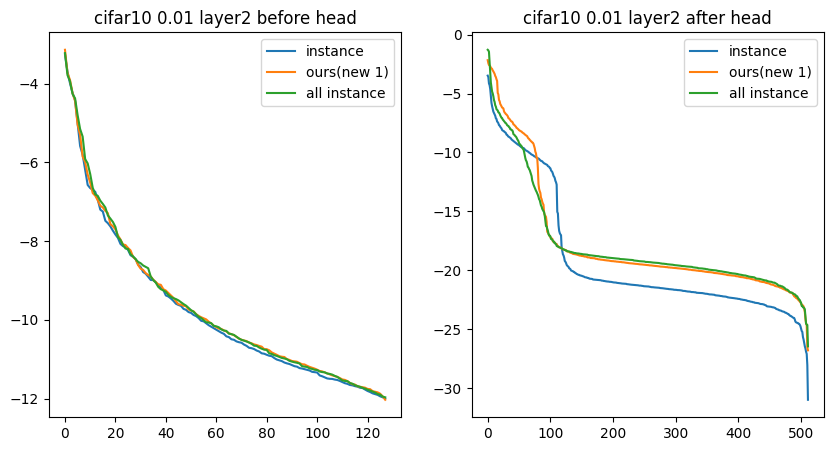

In [16]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(d0[2])
plt.plot(d4[2])
plt.plot(dr[2])
plt.legend(labels=labels)
plt.title(f'{prefix} layer2 before head')

plt.subplot(1, 2, 2)
plt.plot(d0[3])
plt.plot(d4[3])
plt.plot(dr[3])
plt.legend(labels=labels)
plt.title(f'{prefix} layer2 after head')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'cifar10 0.01 layer3 after head')

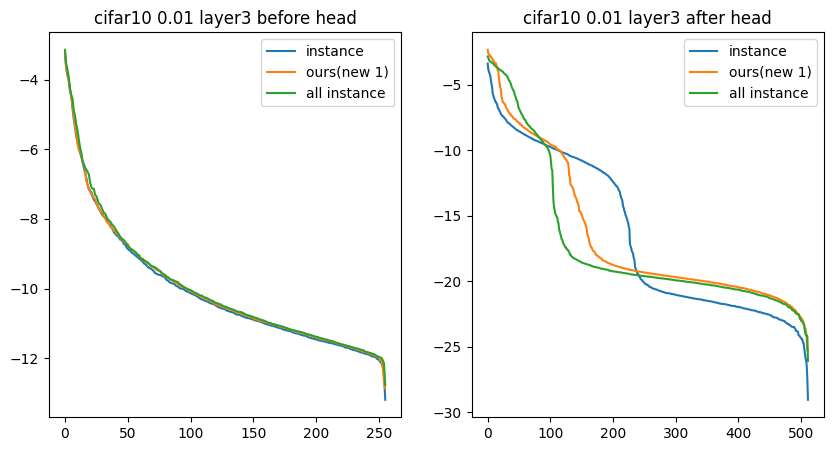

In [17]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(d0[4])
plt.plot(d4[4])
plt.plot(dr[4])
plt.legend(labels=labels)
plt.title(f'{prefix} layer3 before head')

plt.subplot(1, 2, 2)
plt.plot(d0[5])
plt.plot(d4[5])
plt.plot(dr[5])
plt.legend(labels=labels)
plt.title(f'{prefix} layer3 after head')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'cifar10 0.01 layer4 after head')

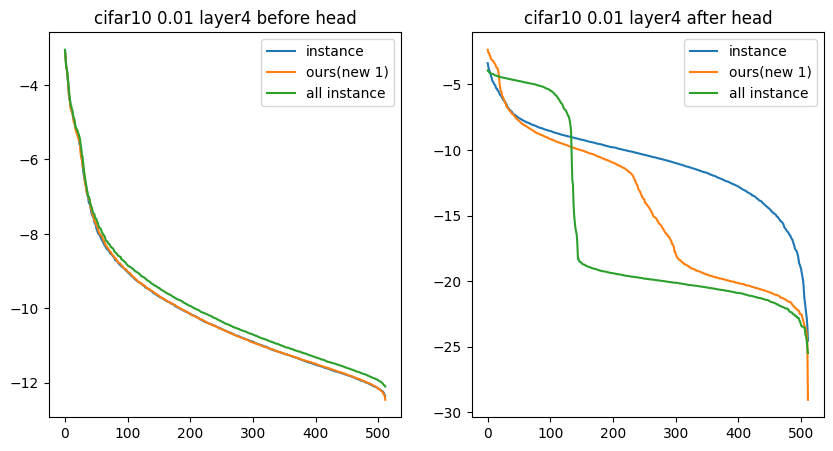

In [18]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(d0[6])
plt.plot(d4[6])
plt.plot(dr[6])
plt.legend(labels=labels)
plt.title(f'{prefix} layer4 before head')

plt.subplot(1, 2, 2)
plt.plot(d0[7])
plt.plot(d4[7])
plt.plot(dr[7])
plt.legend(labels=labels)
plt.title(f'{prefix} layer4 after head')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'cifar10 0.01 fc after head')

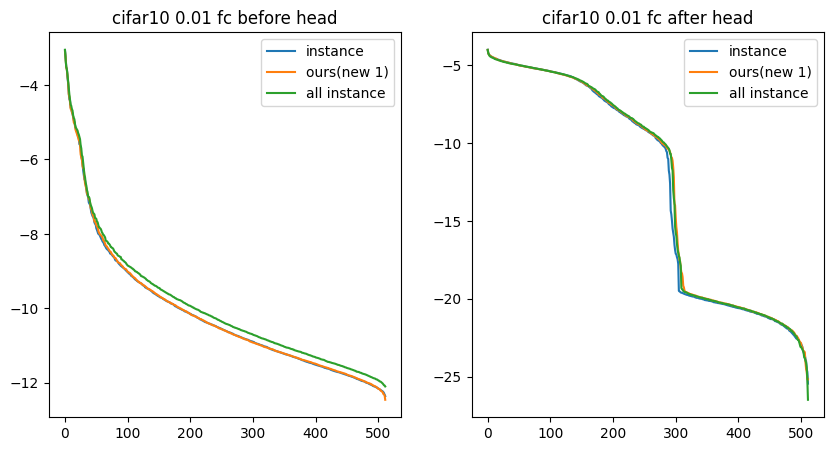

In [19]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(d0[8])
plt.plot(d4[8])
plt.plot(dr[8])
plt.legend(labels=labels)
plt.title(f'{prefix} fc before head')

plt.subplot(1, 2, 2)
plt.plot(d0[9])
plt.plot(d4[9])
plt.plot(dr[9])
plt.legend(labels=labels)
plt.title(f'{prefix} fc after head')